# 1.Setup

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression # Model utama
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion # Tools utama
from sklearn.preprocessing import FunctionTransformer # Untuk custom feature
import nltk

## 1.1 Create Helper Functions

In [22]:
def create_question_feature(text_series):
    """
    Membuat fitur biner yang menandakan apakah sebuah teks mengandung tanda tanya '?'.
    """
    # regex=False memastikan pencarian literal untuk '?'
    return text_series.str.contains('?', regex=False).astype(int).values.reshape(-1, 1)

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Membuat dan menampilkan plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# 2.Load Dataset

In [ ]:
FILE_PATH = "tweet_bersih.csv"
TEST_SIZE = 0.15
RANDOM_STATE = 16

try:
    df = pd.read_csv(FILE_PATH)
    print('Dataset berhasil dimuat')
    print(f'Jumlah data: {len(df)} baris')
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di '{FILE_PATH}'. Pastikan path sudah benar")
    exit()

Dataset berhasil dimuat
Jumlah data: 1815 baris


# 3.Preparing Data

In [24]:
X_text = df['tweet_bersih'].fillna('').astype(str)
y = df['sentimen']

X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_text, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# 4. Create and Train the Model using a Pipeline

In [25]:
print("\n--- Menggunakan scikit-learn Pipeline untuk Logistic Regression ---")

# Mendefinisikan pipeline untuk ekstraksi fitur gabungan
feature_extraction = FeatureUnion([
    ('tfidf', TfidfVectorizer(max_features=800, min_df=3, ngram_range=(1, 3))),
    # Fitur tanda tanya ditarik dari kolom teks mentah X_text_train/test
    ('question_feature', FunctionTransformer(create_question_feature, validate=False))
])

# Buat pipeline utama yang menggabungkan ekstraksi fitur dan classifier
model_pipeline = Pipeline([
    ('features', feature_extraction),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, C=1))
])

# Melatih pipeline dengan data training mentah
print("Memulai training model Logistic Regression...")
model_pipeline.fit(X_text_train, y_train)
print("Training selesai!")


--- Menggunakan scikit-learn Pipeline untuk Logistic Regression ---
Memulai training model Logistic Regression...
Training selesai!


# 5. Prediction and Evaluate the Model


--- Hasil Evaluasi Model Logistic Regression (via Pipeline) ---
Akurasi Data Latih : 0.7931
Akurasi Data Uji   : 0.6703

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

     negatif       0.64      0.70      0.67        90
      netral       0.67      0.68      0.67        91
     positif       0.71      0.63      0.67        92

    accuracy                           0.67       273
   macro avg       0.67      0.67      0.67       273
weighted avg       0.67      0.67      0.67       273



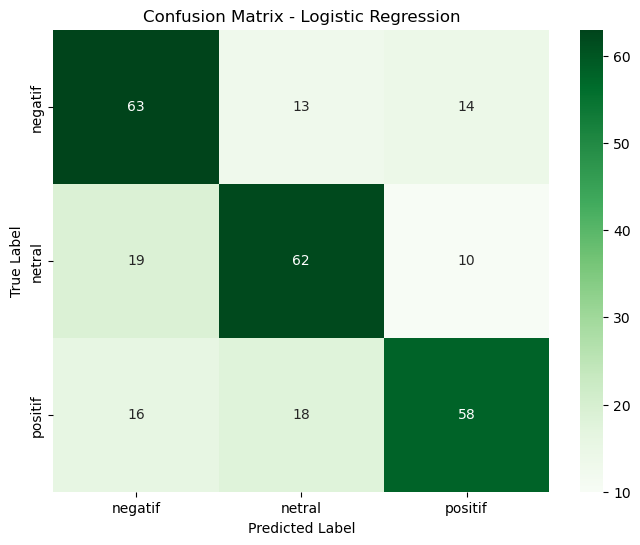

In [26]:
y_pred_test = model_pipeline.predict(X_text_test)
y_pred_train = model_pipeline.predict(X_text_train)

# Menampilkan hasil evaluasi
print("\n--- Hasil Evaluasi Model Logistic Regression (via Pipeline) ---")
print(f"Akurasi Data Latih : {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Akurasi Data Uji   : {accuracy_score(y_test, y_pred_test):.4f}")

print("\nLaporan Klasifikasi Data Uji:")
print(classification_report(y_test, y_pred_test))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_test, classes=model_pipeline.classes_, title='Confusion Matrix - Logistic Regression')
